# Предсказание температуры плавления стали
### Цель проекта
Компании необходимо уменьшить потребление электроэнергии на этапе обработки стали.
### План Работы
1)<a href='#1'>Cоздаем признаки для обучения\
2)<a href='#2'>Посмотрим на данные \
3)<a href='#3'>Обучим модели\
4)<a href='#4'>Выводы

In [1]:
import pandas as pd
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import warnings
from tqdm.notebook import tqdm
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoost
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import seaborn as sns
import numpy
import xgboost
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from functools import reduce

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
pip inatall xgboost

Note: you may need to restart the kernel to use updated packages.


'C:\Users\litvinskaya.m\Anaconda3\New' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
try:
    arc=pd.read_csv('/datasets/final_steel/data_arc.csv')
    bulk=pd.read_csv('/datasets/final_steel/data_bulk.csv')
    bulk_time=pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    gas=pd.read_csv('/datasets/final_steel/data_gas.csv')
    temp=pd.read_csv('/datasets/final_steel/data_temp.csv')
    wire=pd.read_csv('/datasets/final_steel/data_wire.csv')
    wire_time=pd.read_csv('/datasets/final_steel/data_wire_time.csv')
    
except:
    arc=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_arc.csv')
    bulk=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_bulk.csv')
    bulk_time=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_bulk_time.csv')
    gas=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_gas.csv')
    temp=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_temp.csv')
    wire=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_wire.csv')
    wire_time=pd.read_csv(r'C:\Users\litvinskaya.m\Desktop\Материалы курса Яндекс.Практикум\ноутбуки\final project\final_steel\data_wire_time.csv')

In [4]:
for i in [arc,bulk,bulk_time,gas,temp,wire,wire_time]:
    print(i.info())
    print(i.sample(3))
    print()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None
       key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
3914   845  2019-06-03 16:51:12  2019-06-03 16:53:26           0.475568   
5148  1118  2019-06-13 01:23:23  2019-06-13 01:24:26           0.252264   
9094  1970  2019-07-18 14:11:56  2019-07-18 14:14:01           0.455543   

      Реактивная мощность  
3914             0.303480  
5148             0.181161  
9094             0.378295  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3

### Cоздаем признаки для обучения <a id='1'></a>

In [5]:
arc=arc.set_index('key')
bulk=bulk.set_index('key')
bulk_time=bulk_time.set_index('key')
gas=gas.set_index('key')
temp=temp.set_index('key')
wire=wire.set_index('key')
wire_time=wire_time.set_index('key')

In [6]:
wire_time = bulk_time.merge(wire_time, on='key', how='outer')
wire_time.columns = wire_time.columns +'_time'
df = reduce(lambda x,y: pd.merge(x, y, on='key', how='outer'), 
                  [temp, arc, gas, bulk, wire, wire_time])

In [7]:
df = df.rename(columns={'Время замера': 'temp_time_check',
                                    'Температура': 'temp',
                                    'Начало нагрева дугой': 'heat_start', 
                                    'Конец нагрева дугой': 'heat_end', 
                                    'Активная мощность': 'active_power', 
                                    'Реактивная мощность': 'reactive_power',
                                    'Газ 1': 'gas_1'})

In [8]:
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

In [9]:
df = df.dropna(subset=['temp_time_check', 'heat_start', 'heat_end', 'active_power', 'reactive_power'])

In [10]:
df = df.fillna(0)

In [11]:
df[['heat_start', 'heat_end']] = df[['heat_start', 'heat_end']].astype('datetime64[s]')

In [12]:
df['heat_time'] = df['heat_end'] -df['heat_start']

In [13]:
df['heat_time'] = pd.to_timedelta(df['heat_time']).dt.total_seconds().astype(float)

In [14]:
df['full_power'] = (df['active_power']**2 + df['reactive_power']**2)**(0.5)

In [15]:
df1 = pd.pivot_table(df, index='key', values=['temp'], aggfunc=['first', 'last'])
df1.columns = df1.columns.droplevel(1)
df2 = pd.pivot_table(df, index='key', values=['active_power', 'heat_time', 'full_power', 'gas_1',
                                                    'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                                                    'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                                                    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
                                                    'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                                                    'wire_6', 'wire_7', 'wire_8', 'wire_9'], aggfunc='mean')

In [16]:
data = pd.concat((df1, df2), axis=1)

In [17]:
data = data.rename(columns={'first': 'first_temp', 'last': 'last_temp'})

In [18]:
data = data.query('last_temp != 0')

In [19]:
data['bulk_total']= data['bulk_1']+data['bulk_2']+data['bulk_3']+data['bulk_4']+data['bulk_5']+data['bulk_6']+data['bulk_7']+data['bulk_8']+data['bulk_9']+data['bulk_10']+data['bulk_11']+data['bulk_12']+data['bulk_13']+data['bulk_14']+data['bulk_15']
data['wire_total']= data['wire_1']+data['wire_2']+data['wire_3']+data['wire_4']+data['wire_5']+data['wire_6']+data['wire_7']+data['wire_8']+data['wire_9']

In [20]:
def anomalies(data,col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] > (Q1-3*IQR)) & (data[col] < (Q3+3*IQR))]
    return data

In [21]:
columns = ['first_temp', 'last_temp', 'active_power', 'heat_time', 'full_power', 'bulk_total', 'wire_total']

In [22]:

for col in columns:
    data = anomalies(data, col)

### Посмотрим на данные <a id='2'></a>

In [23]:
data.columns

Index(['first_temp', 'last_temp', 'active_power', 'bulk_1', 'bulk_10',
       'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_2',
       'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9',
       'full_power', 'gas_1', 'heat_time', 'wire_1', 'wire_2', 'wire_3',
       'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9',
       'bulk_total', 'wire_total'],
      dtype='object')

<AxesSubplot:>

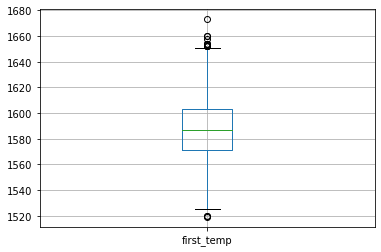

In [24]:

data.boxplot(column='first_temp')

<AxesSubplot:>

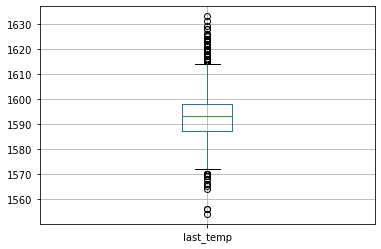

In [25]:

data.boxplot(column='last_temp')

<AxesSubplot:>

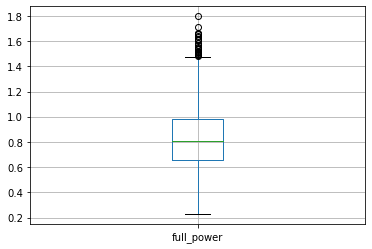

In [26]:

data.boxplot(column='full_power')

<AxesSubplot:>

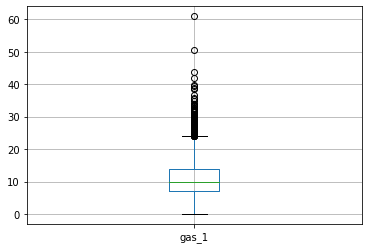

In [27]:
data.boxplot(column='gas_1')

<AxesSubplot:>

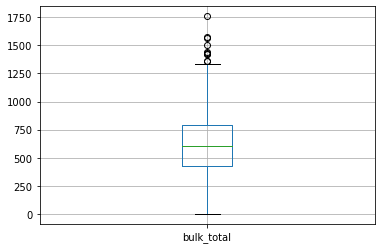

In [28]:
data.boxplot(column='bulk_total')

<AxesSubplot:>

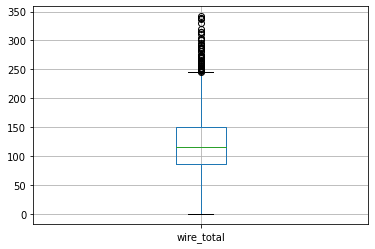

In [29]:
data.boxplot(column='wire_total')

<AxesSubplot:>

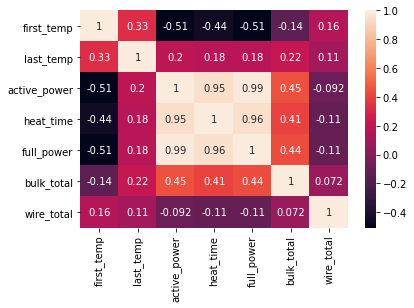

In [30]:
check = ['first_temp', 'last_temp', 'active_power', 'heat_time', 'full_power', 'bulk_total', 'wire_total']
sns.heatmap(data[columns].corr(), annot=True)


In [41]:
#data = data.drop(columns=['heat_time'])

### Обучим модели*  <a id='3'></a>
*модели с плохим результатом будут удалены из финального варианта с проектом

In [42]:
target = data['last_temp']
features = data.drop(columns='last_temp')

In [43]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12)

In [44]:
models = dict()

In [45]:
def submit_model(title, model, X_train, y_train, X_test, y_test): 

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
        
    train_score = mae(y_train, train_pred)
    cv_score = abs(np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')))
    test_score = mae(y_test, test_pred)
    
    def print_score(data_name, score):
        print(f'МАЕ на {data_name}: {score}')
                                                                             
    print(f'Модель "{title}":')
    print_score('обучающей', train_score)
    print_score('кросс-валидация', cv_score)
    print_score('тестовой', test_score)
                           
    models[title] = {'название': title, 
                     'на обучающей выборке': train_score,
                     'на кросс-валидации': cv_score,
                     'на тестовой': test_score}

In [46]:
scaler = ColumnTransformer(transformers=[
    ('std', StandardScaler(), ['first_temp', 'active_power']),
    ('robust', RobustScaler(), ['bulk_1','bulk_2', 'bulk_3', 'bulk_4', 'bulk_5',
                                'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9','bulk_10',
                                'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 
                                'wire_1', 'wire_2', 'wire_3', 'wire_4', 
                                'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9'])
], remainder='passthrough')

In [47]:
p = Pipeline(steps=[('scale', scaler),  # Трансформеры
                    ('forest', RandomForestRegressor(random_state=12))])

In [48]:
p.fit(features_train, target_train)

Pipeline(steps=[('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', StandardScaler(),
                                                  ['first_temp',
                                                   'active_power']),
                                                 ('robust', RobustScaler(),
                                                  ['bulk_1', 'bulk_2', 'bulk_3',
                                                   'bulk_4', 'bulk_5', 'bulk_6',
                                                   'bulk_7', 'bulk_8', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                   'bulk_14', 'bulk_15',
                                                   'wire_1', 'wire_2', 'wire_3',
                                                   'wire_4', 'wire_5', 'wire_6',
     

In [49]:

rf_best = RandomForestRegressor(n_estimators=450, min_samples_split=2, max_depth=10, random_state=12).fit(features_train, target_train)

In [50]:
submit_model('Случайный лес', rf_best, features_train, target_train, features_test, target_test)

Модель "Случайный лес":
МАЕ на обучающей: 3.7715810851232066
МАЕ на кросс-валидация: 6.630525947728565
МАЕ на тестовой: 6.6405225924782


### Выводы <a id='4'></a>

1)План работ потребовал корректривоски в процессе работы с данными, новый план указан в начале проекта\
2)Были небольшие трудности с оценкой коллинеарности данных, но коллеги подсказали как их посмотреть\
3)Выяснилось что больше чем прочее на нагревание влияет мощность и примеси участвующие в производстве. Они,вероятно,меняют химический состав металла, а значит и его свойства\
4) С помощью модели Случайный лес нам удалось достигнуть нужной оценки по метрике МАЕ-6.64, что значит что мы можем с успехом предсказывать время нагрева металла